In [3]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import random as rnd
import pandas as pd
import copy


%matplotlib inline

In [4]:
def drawGz(G,z,c):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    #        : c is number of groups in z
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    seed=328
    rnd.seed(seed)

    # colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
        
    colors=[]
    
    for i in range(c):
        color='#%06x'%rnd.randint(0,0xFFFFFF) #pick 29 colors
        for col in colors:
            if col==color:
                color='#%06x'%rnd.randint(0,0xFFFFFF) #try to keep colors unique
        colors.append(color)


    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True
    

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=1,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [5]:
def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c],dtype=int) # count of stubs from group r to group s
    kpr = np.zeros([c,1],dtype=int) # total degree of group r

    ##### do not modify above here #####

    
    ### YOUR CODE
    
    for e in list(G.edges()):
        for c1 in range(c):
            for c2 in range(c): #iterate through row and column of table
                # print(e)  #prints for debugging
                # print(z[e[0]])
                # print(z[e[1]])
                # print(c1)
                # print(c2)
                if (z[e[0]]==c1 and z[e[1]]==c2): #u to v edge found
                    wrs[c1][c2]+=1
                if (z[e[1]]==c1 and z[e[0]]==c2): #v to u edge found
                    wrs[c1][c2]+=1
                
                # print(wrs)
            kpr[c1][0]=sum(wrs[c1][:]) #kpr is sum of row r
                    
                
        
    ##### do not modify below here #####

    return wrs,kpr

In [6]:
def random_z(nmin,nmax,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    ##### do not modify above here #####

    
    ### YOUR CODE
    
    for i in range(nmin,nmax+1):
        r=rnd.randint(0,c-1)
        z[i]=r
    

    ##### do not modify below here #####

    return z

In [7]:
def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION


In [8]:
def plotLL(LL,pc,n):
    # DO NOT MODIFY THIS FUNCTION
    # This function makes a nice plot of the log-likelihood trajectory
    #
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)

    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()

In [9]:
def makeAMove(G,z,c,f):
    # For each non 'frozen' node in the current partition, this function tries all (c-1) possible group moves for it
    # It returns the combination of [node i and new group r] that produces the best log-likelihood over the non-frozen set
    # input  : G, a graph
    #        : z, a partition of G's nodes
    #        : c, the number of groups
    #        : f, a binary labeling of frozen nodes
    #        : l, list of possible groups
    # output : bestL, the best log-likelihood found
    #        : bestMove, [i,r] the node i and new group r to achieve bestL
    
    bestL = -np.inf            # the best log-likelihood over all considered moves
    for i in G.nodes():        # loop over all nodes i
        if f[i] == 0:          # if i is not frozen
            s = int(z[i])      #  get current label of i
            for r in range(c): #  then loop over all groups r
                #print(f'v[{i}] s = {s}, r={r}, {r!=s}') # for debugging
                
                ##### do not modify above here #####

                
                ## YOUR CODE
                if r != s: # don't care about original group
                    z[i]=r #change group of node
                    wrs,kpr=tabulate_wk(G,z,c)
                    thisL=dcsbm_LogL(wrs,kpr)
                    # print(f'v[{i}] g[{int(s)} --> g[{r}] : {thisL}')
                    if(thisL > bestL): #new model is better than old model
                        bestL=thisL
                        bestMove=[i,r]
                z[i]=s #return to original group
                
                
                
                ##### do not modify below here #####    
                
    return bestL,bestMove

In [10]:
def run_OnePhase(G,z0,c,nmin,nmax):
    # Runs one phase, initialized from partition z0
    # Returns the best partition found in the phase and the list of LogL values for all the phase's partitions
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    import copy      # for copy.deepcopy() function
    n    = G.order() # n, number of nodes
    LL   = []        # stores log-likelihoods over the entire algorithm (via .append)
    halt = 0         # flag: =0 if Lstar > L0 at the end of the phase; =1 if Lstar <= L0

    # initialize the phase
    wrs,kpr = tabulate_wk(G,z0,c)      # wrs, kpr, initial DC-SBM parameters
    L0      = dcsbm_LogL(wrs,kpr)      # store initial DC-SBM log-likelihood
    LL.append(L0)                      # track log-likelihood

    f     = dict.fromkeys(range(nmin,nmax+1), 0) # initially, all nodes unfrozen (tricky python)
    t     = 0                          # number of frozen nodes in this phase
    Lstar = L0                         # initially, z0 has the best LogL
    zstar = copy.deepcopy(z0)          # and z0 is the best partition
    tstar = t                          # tstar = 0
    
    

    # loop over all the nodes in G, making greedy move for each
    zt = copy.deepcopy(z0)             # start the loop at z0
    for j in range(n):
        # print(f'step {j}') # for debugging

        ##### do not modify above here #####

        
        ### YOUR CODE
        LMove,Move=makeAMove(G,zt,c,f)
        t+=1
        LL.append(LMove) #add log likelyhood to list
        f[Move[0]]=1 #freeze
        if(LMove > Lstar): #new move has highest score
            Lstar=LMove #update new score
            zt[Move[0]]=Move[1] #change group of best node
            zstar=copy.deepcopy(zt) #save copy of new zt
            tstar=t #update which number partition is best
            # print(f't={tstar}: new log likelyhood {Lstar} by node {Move[0]} --> group {Move[1]}')
            
            
    if(tstar==0):
        halt=1 #convergence condition met
        
            


        ##### do not modify below here #####

    return zstar,Lstar,LL,halt

In [11]:
def fit_DCSBM(G,c,T,nmin,nmax):
    # Runs the full locally greedy heuristic, with c groups
    # Returns the best partition found, its LogL, and the list of LogL values for all partitions considered
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of all of the phases
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL

    import copy # for copy.deepcopy()
    
    
    # 1.0 locally greedy heuristic setup
    n  = G.order() # n, number of nodes
    LL   = []      # log-likelihoods over the entire algorithm (concat via .extend)
    halt = 0       # convergence flag

    # 2.0 generate initial partition, calculate wrs,kpr, and store the loglikelihood in Lt
    zt      = random_z(nmin,nmax,c)       # z0, initial partition
    wrs,kpr = tabulate_wk(G,zt,c) # wrs, kpr, initial DC-SBM parameters
    Lt      = dcsbm_LogL(wrs,kpr) # store initial DC-SBM log-likelihood

    # 3.0 the main loop
    pc = 0  # counter for number of phases completed
    while not halt:
        # 3.1 visualization of this phase's initial partition
        print(f'phase[{pc}] z[0], logL = {Lt}')
        drawGz(G,zt,c) #commented out to reduce workload on algorithm

        ##### do not modify above here #####

        
        ### YOUR CODE
            
        
        zstar,Lstar,LLt,halt=run_OnePhase(G,zt,c,nmin,nmax)
        
        if(Lstar > Lt): #new best log likelyhood found
            zt=zstar # update best partition
            Lt=Lstar #update best log likelyhood
        
        LL.extend(LLt) # add new log likelyhoods to list
        
        if(pc ==T): #max amount of phases reached, return from function
            return zstar,Lstar,LL,pc
        pc+=1 #increment phase


        ##### do not modify below here #####
    
    print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    return zstar,Lstar,LL,pc

In [12]:
def fit_DCSBM_reps(G,c,T,nmin,nmax,reps):
    BestL=-np.inf
    for r in range(reps):
        print(f'rep #{r+1}')
        zstar,Lstar,LL,pc = fit_DCSBM(G,c,T,nmin,nmax)
        if(Lstar > BestL): #new best log likelyhood found (should occur at least once since BestL starts at -inf)
            BestL=Lstar #copy over all values
            Bestz=zstar
            BestLL=LL
            Bestpc=pc
            Bestrep=r+1 
            

    return Bestz,BestL,BestLL,Bestpc,Bestrep
    
    
    
    
    

In [42]:


def random_z(n,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    # rnd.seed()
    
    z = np.zeros([n], dtype=int)

    ##### do not modify above here #####
    for x in range(n):
        # creating a dictionary of random group labels
        z[x] = rnd.choice([x for x in range(c)])

    return z

def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c]) # count of stubs from group r to group s

    for e in list(G.edges()):
        # loop through all edges and add 1 to every box of the matrix that the edge corresponds to. This will properly
        # double count the stubs since we are flipping the indexes and adding twice.
        wrs[z[e[0]], z[e[1]]] += 1
        wrs[z[e[1]], z[e[0]]] += 1
    # kpr is just the sum of either each row or column, total degree of a group.
    kpr = np.sum(wrs, axis = 0)
    kpr = kpr.T

    return wrs,kpr

def update_wk(wrs, i, G, z, r, s):
    # This function will update the wrs matrix and kpr list given a single node changed groups. This basically allows us to loop over only the nodes edges and not all 
    # the edges in the graph. 
    new_wrs = copy.deepcopy(wrs)
    for e in list(G.edges(i)):
        x = z[e[1]]
        new_wrs[x,s] -= 1
        new_wrs[s,x] -= 1
        new_wrs[x,r] += 1
        new_wrs[r,x] += 1
    new_kpr = np.sum(new_wrs, axis = 0)   
    new_kpr = new_kpr.T
    
    
    # attempt at vectorization
    # n_temp = list(G.adj[i])
    # if len(n_temp) == 0:
    #     new_kpr = np.sum(new_wrs, axis = 0)   
    #     new_kpr = new_kpr.T
    #     return new_wrs, new_kpr
    # labels = z[n_temp]
    # for y in range(wrs.shape[0]):
    #     if y == 0:
    #         temp = len(labels) - np.count_nonzero(labels)
    #     else:
    #         temp = np.count_nonzero(labels == y)
    #     new_wrs[s,y] -= temp
    #     new_wrs[y,s] -= temp
    #     new_wrs[r,y] += temp
    #     new_wrs[y,r] += temp

    return new_wrs,new_kpr

def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
            
    # utilization of matrix symmetry below
    # for r in range(c):
    #     for s in range(r,c):
    #         if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
    #             temp = 0 # define 0^0 = 1
    #         else:
    #             if r != s:
    #                 temp = 2*wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
    #             else:
    #                 temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
    #         logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION

def plotLL(LL,pc,n):
    # DO NOT MODIFY THIS FUNCTION
    # This function makes a nice plot of the log-likelihood trajectory
    #
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)

    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()
    
def makeAMove_op(G,z,c,f, wrs):
# For each non 'frozen' node in the current partition, this function tries all (c-1) possible group moves for it
# It returns the combination of [node i and new group r] that produces the best log-likelihood over the non-frozen set
# input  : G, a graph
#        : z, a partition of G's nodes
#        : c, the number of groups
#        : f, a binary labeling of frozen nodes
# output : bestL, the best log-likelihood found
#        : bestMove, [i,r] the node i and new group r to achieve bestL
    bestL = -np.inf # the best log-likelihood over all considered moves

    for i in G.nodes():        # loop over all nodes i
        if f[i] == 0:          # if i is not frozen
            s = int(z[i]) #  get current label of i
            for r in range(c): #  then loop over all groups r
                #print(f'v[{i}] s = {s}, r={r}, {r!=s}') # for debugging
                
                ##### do not modify above here #####
                if s != r:
                    # updating the wrs and kpr values for the current label distribution
                    cwrs, ckpr = update_wk(wrs, i, G, z, r, s)
                    
                    # calculating the log likelyhood of the current label distribution
                    currentL = dcsbm_LogL(cwrs, ckpr)
                    
                    # checking if it is better than the best one so far, and if it is replacing it with the current one, and assigning the best move as the current node and label that it was reassigned to
                    if currentL > bestL:
                        bestL = currentL
                        bestMove = [i, r]
                        best_wrs = cwrs
                        best_kpr = ckpr
                    
                ##### do not modify below here #####    
                
    return bestL,bestMove, best_wrs, best_kpr


def run_OnePhase_op(G,z0,c,wrs,kpr):
    # Runs one phase, initialized from partition z0
    # Returns the best partition found in the phase and the list of LogL values for all the phase's partitions
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    #        : wrs, initial wrs values
    #        : kpr, initial kpr values
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    import copy      # for copy.deepcopy() function
    n    = G.order() # n, number of nodes
    LL   = []        # stores log-likelihoods over the entire algorithm (via .append)
    halt = 0         # flag: =0 if Lstar > L0 at the end of the phase; =1 if Lstar <= L0

    # initialize the phase
    L0      = dcsbm_LogL(wrs,kpr)      # store initial DC-SBM log-likelihood
    LL.append(L0)                      # track log-likelihood

    f     = dict.fromkeys(range(n), 0) # initially, all nodes unfrozen (tricky python)
    t     = 0                          # number of frozen nodes in this phase
    Lstar = L0                         # initially, z0 has the best LogL
    zstar = copy.deepcopy(z0)          # and z0 is the best partition
    tstar = t                          # tstar = 0
    c_wrs = copy.deepcopy(wrs)
    # loop over all the nodes in G, making greedy move for each
    zt = copy.deepcopy(z0)             # start the loop at z0
    for j in range(n):
        # determining the best move
        bestL, bestMove, c_wrs, c_kpr = makeAMove_op(G, zt, c, f, c_wrs)
        
        # making the best move
        zt[bestMove[0]] = bestMove[1]
        
        # freezing the node that was changed
        f[bestMove[0]] = 1
        
        # appending the value to the list of LL's
        LL.append(bestL)
        
        # if the LL is better than the best one so far, store it and then store the group structure
        if bestL > Lstar:
            Lstar = bestL
            zstar = copy.deepcopy(zt)
            best_wrs = c_wrs
            best_kpr = c_kpr
    
    # if no progress was made, halt
    if Lstar <= L0:
        halt = 1
        best_wrs = wrs
        best_kpr = kpr
        


        ##### do not modify below here #####
    
    return zstar,Lstar,LL,halt, best_wrs, best_kpr

def fit_DCSBM_op(G,c,T):
    # Runs the full locally greedy heuristic, with c groups
    # Returns the best partition found, its LogL, and the list of LogL values for all partitions considered
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL
    
    # 1.0 locally greedy heuristic setup
    n  = G.order() # n, number of nodes
    LL   = []      # log-likelihoods over the entire algorithm (concat via .extend)
    halt = 0       # convergence flag

    # 2.0 generate initial partition, calculate wrs,kpr, and store the loglikelihood in Lt
    zt      = random_z(n,c)       # z0, initial partition
    wrs,kpr = tabulate_wk(G,zt,c) # wrs, kpr, initial DC-SBM parameters
    Lt      = dcsbm_LogL(wrs,kpr) # store initial DC-SBM log-likelihood

    # 3.0 the main loop
    pc = 0  # counter for number of phases completed
    zstar = copy.deepcopy(zt)
    Lstar = Lt
    while not halt:
        # 3.1 visualization of this phase's initial partition
        print(f'phase[{pc}] z[0], logL = {Lstar}')
        # drawGz(G,zt,c)
       

        ##### do not modify above here #####
        # run a phase
        zt,Lc,LL_c,halt, wrs, kpr = run_OnePhase_op(G, zt, c, wrs, kpr)
    
        # if the LL calculated is better than the one that started the phase or the previous best one, replace it and save the group partition
        if Lc > Lstar:
            Lstar = Lc
            zstar = zt
        # extend the list of LL's
        LL.extend(LL_c)
        # update counter
        pc += 1
        # if the counter reached T, break out of the loop
        if pc >= T:
            break
    
    
    
    print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    
    return zstar,Lstar,LL,pc

def fit_DCSBM_op_reps(G,c,T,reps):
    import copy
    # set initial best LL
    bestL = -np.inf
    # innitialize count var
    count = 0
    # loop through the reps
    for x in range(reps):
        # fit the group structure, check if LL better than previous best, replace if true, increment count
        print(f'rep #{x+1}')
        zstar,Lstar,LL,pc = fit_DCSBM_op(G,c,T)
        if Lstar > bestL:
            bestL = Lstar
            bestz = copy.deepcopy(zstar)
            count = x+1
    
    return bestL, bestz, count,pc

In [43]:
##settings to create subgraph for analysis
##run this cell before next cells
nmin=49
nmax=148

reading the network file  : virus_virus_network.txt
reading the metadata file : virus_family_metadata

number of nodes, n  = 586
number of edges, m  = 42475
mean degree,    <k> = 144.97
Subgraph:
number of nodes, n  = 100
number of edges, m  = 1114
mean degree,    <k> = 22.28


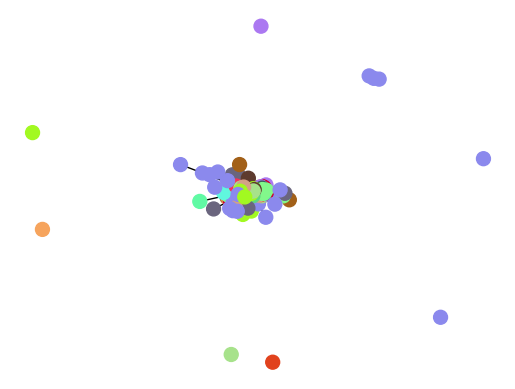

In [49]:
fname1='virus_virus_network.txt'
fname2='virus_family_metadata'


# read in the network file (an edge list)
print(f'reading the network file  : {fname1}')
G = nx.read_edgelist('./' + fname1, delimiter=', ', nodetype=int)  # import simple graph, index nodes by integers (not strings)





#add nodes without edges(we know that there are 586 nodes total)
nodes_missing=list()
for i in range(1,587):
    x=True
    for j in nx.nodes(G):
        if(i==j):
            x=False
    if x==True:
        nodes_missing.append(i)
        
G.add_nodes_from(nodes_missing)
        
        
#remap values to go from 1-586 to 0-585


        
remap={i:i-1 for i in range(1,587)}

nx.relabel_nodes(G,remap,copy=False)
        

        


# read in the node metadata
print(f'reading the metadata file : {fname2}\n')
f = open('./' + fname2,'r')
labels = []
for line in f:
    
    labels.append(line.split(',')[1].rstrip('\n')) # remove the index name for the metadata and strip the \n

s=set()
for i in range(0,len(labels)):
    s.add(labels[i]) #find each unique label
    

# for each node i in G, add (j: j's label) to a dictionary z

# print(labels)
z = {}

for i in range(0,len(labels)):
    z[i] = labels[i]
        


slist=list(s)

zints={}
for i in range(len(slist)):
    for j in z.keys():
        if z[j]==slist[i]:
            zints[j]=i


    
    
n=G.order()
m=G.size()
kmean=2*m/n

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)



c=len(s)



G2=nx.Graph(nx.subgraph(G,range(nmin,nmax+1)))

newlabels={i:i-nmin for i in range(nmin,nmax+1)}

nx.relabel_nodes(G2,newlabels,copy=False)

z2={i-nmin:z[i] for i in range(nmin,nmax+1)}

# print(z2)

s2=set()
for i in z2.keys():
    s2.add(z2[i])

slist2=list(s2)

z2ints={}
for i in range(len(slist2)):
    for j in z2.keys():
        if z2[j]==slist2[i]:
            z2ints[j]=i

            
# print(z2ints)

c2=len(s2)

n=G2.order()
m=G2.size()
kmean=2*m/n

print('Subgraph:')
print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)
# print(z2)
# print(c2)

# print(zints)

drawGz(G2,z2ints,c2)
# drawGz(G,zints,c)




        


before DCSBM:
{0: 'Rhabdoviridae', 1: 'Parvoviridae', 2: 'Parvoviridae', 3: 'Parvoviridae', 4: 'Polyomaviridae', 5: 'Retroviridae', 6: 'Reoviridae', 7: 'Asfarviridae', 8: 'Picornaviridae', 9: 'Bunyaviridae', 10: 'Herpesviridae', 11: 'Herpesviridae', 12: 'Parvoviridae', 13: 'Arenaviridae', 14: 'Arenaviridae', 15: 'Bunyaviridae', 16: 'Bunyaviridae', 17: 'Bunyaviridae', 18: 'Flaviviridae', 19: 'Unassigned', 20: 'Rhabdoviridae', 21: 'Hepadnaviridae', 22: 'Flaviviridae', 23: 'Bunyaviridae', 24: 'Herpesviridae', 25: 'Herpesviridae', 26: 'Togaviridae', 27: 'Rhabdoviridae', 28: 'Reoviridae', 29: 'Polyomaviridae', 30: 'Bunyaviridae', 31: 'Bunyaviridae', 32: 'Reoviridae', 33: 'Flaviviridae', 34: 'Togaviridae', 35: 'Rhabdoviridae', 36: 'Bunyaviridae', 37: 'Arenaviridae', 38: 'Togaviridae', 39: 'Rhabdoviridae', 40: 'Bunyaviridae', 41: 'Bunyaviridae', 42: 'Rhabdoviridae', 43: 'Polyomaviridae', 44: 'Bunyaviridae', 45: 'Reoviridae', 46: 'Flaviviridae', 47: 'Bornaviridae', 48: 'Flaviviridae', 49: 'Ade

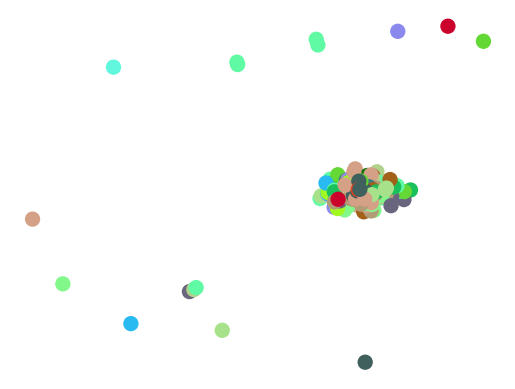

rep #1
phase[0] z[0], logL = -964007.5212292128
phase[1] z[0], logL = -945140.7450207194
phase[2] z[0], logL = -938413.966703712
phase[3] z[0], logL = -937318.4129970092
phase[4] z[0], logL = -936804.4096943382
phase[5] z[0], logL = -935818.9637046242
phase[6] z[0], logL = -935733.4886871859
phase[7] z[0], logL = -935521.2214297038
phase[8] z[0], logL = -935440.7502450628
 --> WE HAVE CONVERGENCE <-- 
after DCSBM:


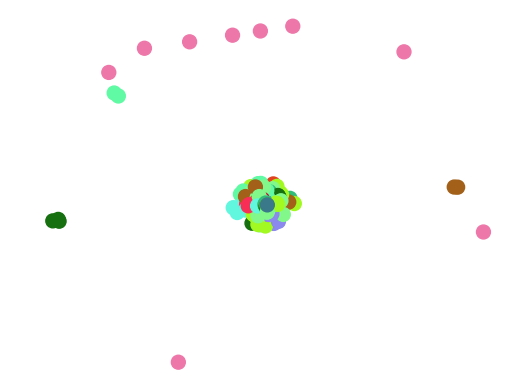

{81: 'Reoviridae', 148: 'Reoviridae', 213: 'Reoviridae', 458: 'Reoviridae', 560: 'Reoviridae', 18: 'Orthomyxoviridae', 21: 'Orthomyxoviridae', 123: 'Orthomyxoviridae', 197: 'Orthomyxoviridae', 292: 'Orthomyxoviridae', 296: 'Orthomyxoviridae', 321: 'Orthomyxoviridae', 324: 'Orthomyxoviridae', 326: 'Orthomyxoviridae', 334: 'Orthomyxoviridae', 373: 'Orthomyxoviridae', 403: 'Orthomyxoviridae', 413: 'Orthomyxoviridae', 514: 'Orthomyxoviridae', 541: 'Orthomyxoviridae', 132: 'Parvoviridae', 134: 'Parvoviridae', 322: 'Parvoviridae', 466: 'Parvoviridae', 536: 'Parvoviridae', 561: 'Parvoviridae', 33: 'Filoviridae', 141: 'Filoviridae', 142: 'Filoviridae', 287: 'Filoviridae', 314: 'Filoviridae', 320: 'Filoviridae', 349: 'Filoviridae', 353: 'Filoviridae', 382: 'Filoviridae', 450: 'Filoviridae', 533: 'Filoviridae', 546: 'Filoviridae', 9: 'Togaviridae', 42: 'Togaviridae', 45: 'Togaviridae', 46: 'Togaviridae', 67: 'Togaviridae', 76: 'Togaviridae', 78: 'Togaviridae', 116: 'Togaviridae', 138: 'Togavirid

In [45]:

T=10
reps=1
print(f'before DCSBM:')
print(z)
drawGz(G,zints,c)
bestL,zstar,bestrep,bestpc=fit_DCSBM_op_reps(G,c,T,reps)



print(f'after DCSBM:')
drawGz(G,zstar,c)


In [56]:
#convert int dict to string dict
zstr={}
for i in range(len(slist)):
    for j in range(len(zstar)):
        if zstar[j]==i:
            zstr[j]=slist[i]
            

            
for key,value in sorted(zstr.items(),key=lambda x:x[0]):
    print(f'node {key}: {value}')

node 0: Togaviridae
node 1: Hepeviridae
node 2: Hepeviridae
node 3: Circoviridae
node 4: Hepeviridae
node 5: Papillomaviridae
node 6: Astroviridae
node 7: Filoviridae
node 8: Circoviridae
node 9: Asfarviridae
node 10: Togaviridae
node 11: Togaviridae
node 12: Coronaviridae
node 13: Circoviridae
node 14: Arteriviridae
node 15: Arteriviridae
node 16: Adenoviridae
node 17: Herpesviridae
node 18: Bornaviridae
node 19: Polyomaviridae
node 20: Polyomaviridae
node 21: Bornaviridae
node 22: Unassigned
node 23: Arenaviridae
node 24: Herpesviridae
node 25: Herpesviridae
node 26: Adenoviridae
node 27: Coronaviridae
node 28: Papillomaviridae
node 29: Papillomaviridae
node 30: Papillomaviridae
node 31: Circoviridae
node 32: Picornaviridae
node 33: Parvoviridae
node 34: Adenoviridae
node 35: Arenaviridae
node 36: Arteriviridae
node 37: Arenaviridae
node 38: Circoviridae
node 39: Togaviridae
node 40: Anelloviridae
node 41: Herpesviridae
node 42: Asfarviridae
node 43: Circoviridae
node 44: Arterivirid

586
